# Algoritmo k-Nearest Neighbors

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sb
 
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Para nuestro ejercicio tomaremos 257 registros con Opiniones de usuarios sobre una app (Reviews). Utilizaremos 2 columnas de datos como fuente de alimento del algoritmo. Recordad que sólo tomaré 2 features para poder graficar en 2 dimensiones, PERO para un problema “en la vida real” conviene tomar más características de lo que sea que queramos resolver. Esto es únicamente con fines de enseñanza. 

Las columnas que utilizaremos serán: wordcount con la cantidad de palabras utilizadas y sentimentValue con un valor entre -4 y 4 que indica si el comentario fue valorado como positivo o negativo. Nuestras etiquetas, serán las estrellas que dieron los usuarios a la app, que son valores discretos del 1 al 5.

Podemos pensar que si el usuario puntúa con más estrellas, tendrá un sentimiento positivo, pero no necesariamente siempre es así.

In [2]:
dt = pd.read_csv("data/reviews_sentiment.csv",sep=';')
dt.head(10)

,Review Title,Review Text,wordcount,titleSentiment,textSentiment,Star Rating,sentimentValue
0,Sin conexión,Hola desde hace algo más de un mes me pone sin...,23,negative,negative,1,-0.486389
1,faltan cosas,Han mejorado la apariencia pero no,20,negative,negative,1,-0.586187
2,Es muy buena lo recomiendo,Andres e puto amoooo,4,NaN,negative,1,-0.602240
3,Version antigua,Me gustana mas la version anterior esta es mas...,17,NaN,negative,1,-0.616271
4,Esta bien,Sin ser la biblia.... Esta bien,6,negative,negative,1,-0.651784
5,Buena,Nada del otro mundo pero han mejorado mucho,8,positive,negative,1,-0.720443
6,De gran ayuda,"Lo malo q necesita de …,pero la app es muy buena",23,positive,negative,1,-0.726825
7,Muy buena,"Estaba más acostumbrado al otro diseño, pero e...",16,positive,negative,1,-0.736769
8,Ta to guapa.,Va de escándalo,21,positive,negative,1,-0.765284
9,Se han corregido,Han corregido muchos fallos pero el diseño es ...,13,negative,negative,1,-0.797961


Aprovechamos para realizar un breve resumen de los datos

In [3]:
dt.describe()

,wordcount,Star Rating,sentimentValue
count,257.000000,257.000000,257.000000
mean,11.501946,3.420233,0.383849
std,13.159812,1.409531,0.897987
min,1.000000,1.000000,-2.276469
25%,3.000000,3.000000,-0.108144
50%,7.000000,3.000000,0.264091
75%,16.000000,5.000000,0.808384
max,103.000000,5.000000,3.264579


In [4]:
dt.dtypes

Review Title       object
Review Text        object
wordcount           int64
titleSentiment     object
textSentiment      object
Star Rating         int64
sentimentValue    float64
dtype: object

Son 257 registros. Las estrellas lógicamente vemos que van del 1 al 5. La cantidad de palabras van de 1 sóla hasta 103. y las valoraciones de sentimiento están entre -2.27 y 3.26 con una media de 0,38 y a partir del desvío estándar podemos ver que la mayoría están entre 0,38-0,89 y 0,38+0,89.

Al ejecutar describe() solo nos describe las variables numericas

### Balance de datos

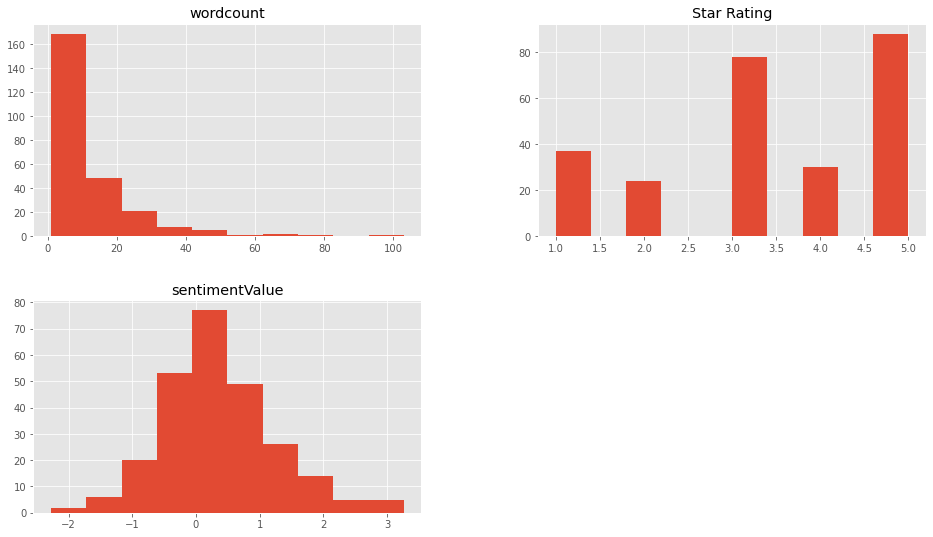

In [5]:
dt.hist()
plt.show()

Vemos que la distribución de “estrellas” no está balanceada… esto no es bueno. Convendría tener las mismas cantidades en las salidas, para no tener resultados “tendenciosos”. Para este ejercicio lo dejaremos así, pero en la vida real, debemos equilibrarlos. La gráfica de Valores de Sentimientos parece bastante una campana movida levemente hacia la derecha del cero y la cantidad de palabras se centra sobre todo de 0 a 10. Veamos cual es la distribución entre las etiquetas que tenemos para las estrellas

In [6]:
print(dt.groupby('Star Rating').size())

Star Rating
1    37
2    24
3    78
4    30
5    88
dtype: int64


C:\Users\vicen\anaconda3\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\vicen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


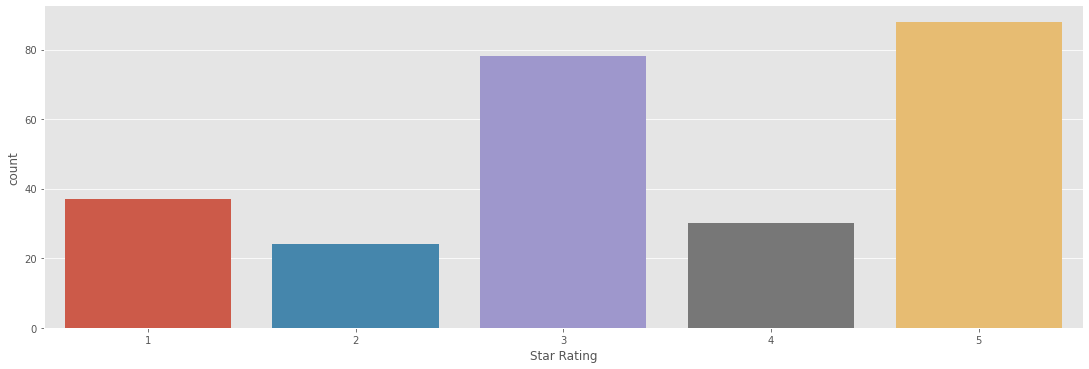

In [7]:
sb.factorplot('Star Rating',data=dt,kind="count", aspect=3)

C:\Users\vicen\anaconda3\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\vicen\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


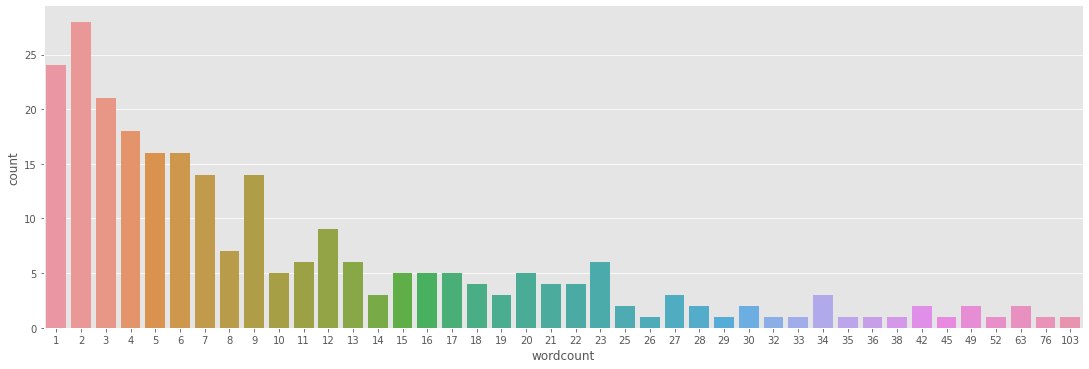

In [8]:
sb.factorplot('wordcount',data=dt,kind="count", aspect=3)

Creamos nuestro conjuntos de entrenamiento y test para una validación honesta de nuestro modelo

In [9]:
X = dt[['wordcount','sentimentValue']].values
y = dt['Star Rating'].values
 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Usamos la librería scikit-learn que tiene muchos algoritmos de machine learning para usar el algoritmos KNN

In [10]:
n_neighbors = 7
 
knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.89
Accuracy of K-NN classifier on test set: 0.87


Vemos que la precisión que nos da es de 87% en el set de entrenamiento y del 86% para el de test.

NOTA: como verán utilizamos la clase KNeighborsClassifier de SciKit Learn puesto que nuestras etiquetas son valores discretos (estrellas del 1 al 5). Pero deben saber que también existe la clase KneighborsRegressor para etiquetas con valores continuos.

### Métricas del modelo

In [11]:
pred = knn.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[10  0  1  0  0]
 [ 0  2  0  0  0]
 [ 0  1 22  0  1]
 [ 0  0  2  8  1]
 [ 0  0  4  0 26]]
              precision    recall  f1-score   support

           1       1.00      0.91      0.95        11
           2       0.67      1.00      0.80         2
           3       0.76      0.92      0.83        24
           4       1.00      0.73      0.84        11
           5       0.93      0.87      0.90        30

    accuracy                           0.87        78
   macro avg       0.87      0.88      0.86        78
weighted avg       0.89      0.87      0.87        78



In [12]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred)

0.8717948717948718

Como se ve la puntuación F1 es del 87%, bastante buena. NOTA: recuerden que este es sólo un ejercicio para aprender y tenemos MUY pocos registros totales y en nuestro conjunto de test. Por ejemplo de 2 estrellas sólo tiene 1 valoración y esto es evidentemente insuficiente.

Ahora realizaremos la grafica con la clasificación obtenida, la que nos ayuda a ver fácilmente en donde caerán las predicciones. NOTA: al ser 2 features, podemos hacer la gráfica 2D y si fueran 3 podría ser en 3D. Pero para usos reales, podríamos tener  más de 3 dimensiones y no importaría  poder visualizarlo sino el resultado del algoritmo.

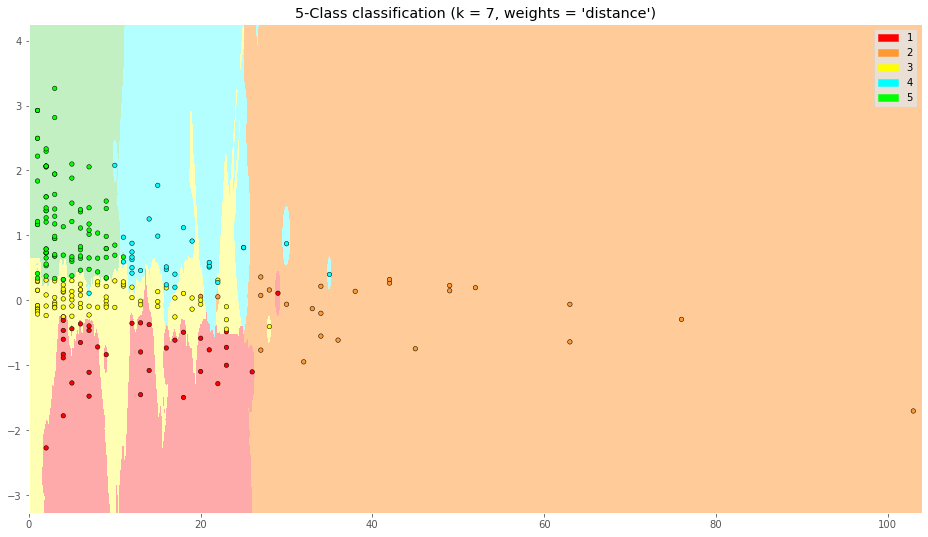

In [13]:
import warnings
warnings.filterwarnings("ignore")

h = .02  # step size in the mesh
 
# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#ffcc99', '#ffffb3','#b3ffff','#c2f0c2'])
cmap_bold = ListedColormap(['#FF0000', '#ff9933','#FFFF00','#00ffff','#00FF00'])
 
# we create an instance of Neighbours Classifier and fit the data.
clf = KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(X, y)
 
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
 
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
 
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
    
patch0 = mpatches.Patch(color='#FF0000', label='1')
patch1 = mpatches.Patch(color='#ff9933', label='2')
patch2 = mpatches.Patch(color='#FFFF00', label='3')
patch3 = mpatches.Patch(color='#00ffff', label='4')
patch4 = mpatches.Patch(color='#00FF00', label='5')
plt.legend(handles=[patch0, patch1, patch2, patch3,patch4])
 
    
plt.title("5-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, 'distance'))
 
plt.show()

Es decir que “a ojo” una review de 20 palabras y Sentimiento 1, nos daría una valoración de 4 (zona celeste).

Con estas zonas podemos intuir ciertas características de los usuarios que usan y valoran la app:

- Los usuarios que ponen 1 estrella tienen sentimiento negativo y hasta 25 palabras.
- Los usuarios que ponen 2 estrellas dan muchas explicaciones (hasta 100 palabras) y su sentimiento puede variar entre negativo y algo positivo.
- Los usuarios que ponen 3 estrellas son bastante neutrales en sentimientos, puesto que están en torno al cero y hasta unas 25 palabras.
- Los usuarios que dan 5 estrellas son bastante positivos (de 0,5 en adelante, aproximadamente) y ponen pocas palabras (hasta 10).

### Ejercicio

Ahora que sabéis implementar el KNN, me gustaría que hicierais un pequeño código aprovechando lo que habéis usado arriba para averiguar cual es el valor de K que hace que mejore el score f1. Probad los valores entre 1 y 10

### Ejercicio

Usando el código del primer ejercicio implementa el KNN de K=1. Qué scores f1 obtenemos?